# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [6]:
data_dir = 'data'
!pip install matplotlib==2.0.2
!pip install tqdm
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Extracting mnist: 100%|██████████| 60.0k/60.0k [00:08<00:00, 7.24kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

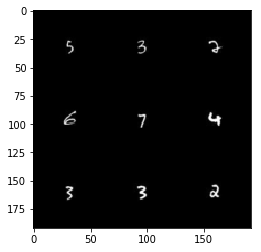

In [29]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 64, 64, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

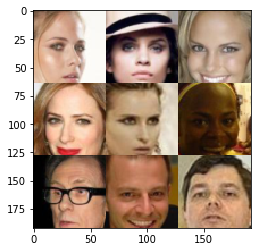

In [30]:
show_n_images = 9

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 64, 64, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [32]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_r = tf.placeholder(tf.float32, shape=[None,image_height, image_width, image_channels], name='inputs_r')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='inputs_z')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return (inputs_r, inputs_z, lrate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        
        l1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='SAME')
        lrelu1 = tf.maximum(0.01 * l1, l1)
        
        l2 = tf.layers.conv2d(lrelu1, 256, 5, strides=2, padding='SAME')
        bnorm2 = tf.layers.batch_normalization(l2, training=True)
        lrelu2 = tf.maximum(0.01 * bnorm2, bnorm2)
        
        l3 = tf.layers.conv2d(lrelu2, 512, 5, strides=2, padding='SAME')
        bnorm3 = tf.layers.batch_normalization(l3, training=True)
        lrelu3 = tf.maximum(0.01 * bnorm3, bnorm3)
        
        flatten = tf.reshape(lrelu3, [-1, 4*4*512])
        
        logits = tf.layers.dense(flatten, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start(

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [34]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
       
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
       
        
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=1, padding='same',kernel_initializer =tf.random_normal_initializer(stddev=0.05))
        
        
        
        out = tf.tanh(logits)
        
  
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [35]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [36]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [43]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, image_channels)
    disc_opt, gen_opt = model_opt(disc_loss, gen_loss, lr, beta1)
    
    saver = tf.train.Saver()
    
    steps = 0
    total_steps = epoch_count * batch_size
    losses = []
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # TODO: Train Model
                steps += 1
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(
                    disc_opt, 
                    feed_dict={
                        input_real: batch_images, input_z: batch_z, lr: learning_rate 
                    }
                )
                _ = sess.run(
                    gen_opt, 
                    feed_dict={
                        input_real: batch_images, 
                        input_z: batch_z, 
                        lr:learning_rate
                    }
                )
                if steps == 1:
                    print('initial output:')
                    show_generator_output(sess, 9, input_z, image_channels, data_image_mode)
                    
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = disc_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = gen_loss.eval({input_z: batch_z})

                    print("{}-Epoch {}/{}...".format(steps, epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    # show samples
                    show_generator_output(sess, 9, input_z, image_channels, data_image_mode)
                    

        saver.save(sess, './generator.ckpt')
                
    return losses
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

initial output:


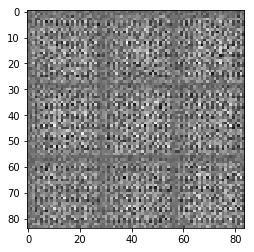

Epoch 1/2... Discriminator Loss: 0.4665... Generator Loss: 4.2218
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 9.3279
Epoch 1/2... Discriminator Loss: 0.3642... Generator Loss: 5.7098
Epoch 1/2... Discriminator Loss: 0.4863... Generator Loss: 10.2324
Epoch 1/2... Discriminator Loss: 0.3607... Generator Loss: 6.9424
Epoch 1/2... Discriminator Loss: 0.3361... Generator Loss: 6.9268
Epoch 1/2... Discriminator Loss: 0.3366... Generator Loss: 5.8362
Epoch 1/2... Discriminator Loss: 14.6088... Generator Loss: 0.0000
Epoch 1/2... Discriminator Loss: 0.6347... Generator Loss: 1.9349
Epoch 1/2... Discriminator Loss: 0.5505... Generator Loss: 2.2593


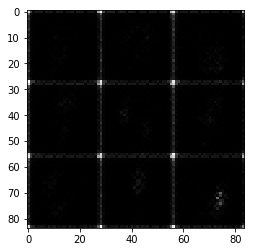

Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.0410
Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.7474
Epoch 1/2... Discriminator Loss: 1.5136... Generator Loss: 0.5527
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 2.2099
Epoch 1/2... Discriminator Loss: 1.6565... Generator Loss: 0.4142
Epoch 1/2... Discriminator Loss: 0.9069... Generator Loss: 1.4275
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 2.6447
Epoch 1/2... Discriminator Loss: 1.0559... Generator Loss: 0.8556
Epoch 1/2... Discriminator Loss: 1.6178... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 0.8202... Generator Loss: 1.3288


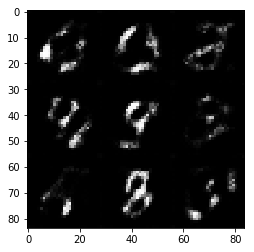

Epoch 1/2... Discriminator Loss: 2.3895... Generator Loss: 0.2061
Epoch 1/2... Discriminator Loss: 0.8001... Generator Loss: 1.5105
Epoch 1/2... Discriminator Loss: 0.8871... Generator Loss: 1.1123
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.7641
Epoch 1/2... Discriminator Loss: 1.0145... Generator Loss: 1.0292
Epoch 1/2... Discriminator Loss: 0.8057... Generator Loss: 2.3352
Epoch 1/2... Discriminator Loss: 1.1257... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.2220... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.5950... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 0.8698... Generator Loss: 1.2822


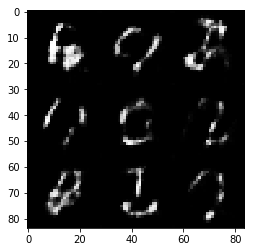

Epoch 1/2... Discriminator Loss: 1.0193... Generator Loss: 1.6473
Epoch 1/2... Discriminator Loss: 1.5988... Generator Loss: 0.4252
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.1528
Epoch 1/2... Discriminator Loss: 1.1154... Generator Loss: 2.1464
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.6187
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 0.6657
Epoch 1/2... Discriminator Loss: 0.8873... Generator Loss: 1.4572
Epoch 1/2... Discriminator Loss: 1.5683... Generator Loss: 0.4590
Epoch 1/2... Discriminator Loss: 1.7219... Generator Loss: 3.8797
Epoch 1/2... Discriminator Loss: 1.2545... Generator Loss: 0.6562


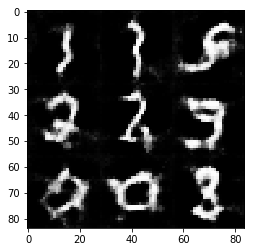

Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.0297... Generator Loss: 1.6114
Epoch 1/2... Discriminator Loss: 1.6620... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.5891
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 1.4591
Epoch 1/2... Discriminator Loss: 0.9376... Generator Loss: 1.3735
Epoch 1/2... Discriminator Loss: 0.9536... Generator Loss: 1.0254
Epoch 1/2... Discriminator Loss: 1.1351... Generator Loss: 2.8540
Epoch 1/2... Discriminator Loss: 0.8927... Generator Loss: 1.1136


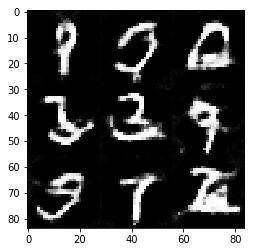

Epoch 1/2... Discriminator Loss: 1.1816... Generator Loss: 0.8369
Epoch 1/2... Discriminator Loss: 0.8962... Generator Loss: 1.8336
Epoch 1/2... Discriminator Loss: 0.8437... Generator Loss: 1.4164
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 2.8091
Epoch 1/2... Discriminator Loss: 0.8556... Generator Loss: 1.1904
Epoch 1/2... Discriminator Loss: 0.9206... Generator Loss: 1.1039
Epoch 1/2... Discriminator Loss: 0.9928... Generator Loss: 0.9980
Epoch 1/2... Discriminator Loss: 0.7338... Generator Loss: 1.5478
Epoch 1/2... Discriminator Loss: 1.6452... Generator Loss: 0.4333
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.6458


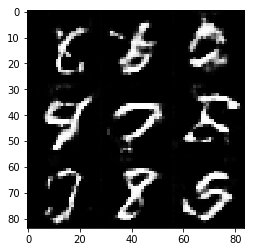

Epoch 1/2... Discriminator Loss: 1.6215... Generator Loss: 0.5613
Epoch 1/2... Discriminator Loss: 0.6692... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.8936
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.5970
Epoch 1/2... Discriminator Loss: 1.1662... Generator Loss: 2.9811
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 1.1522
Epoch 1/2... Discriminator Loss: 0.9110... Generator Loss: 1.1849
Epoch 1/2... Discriminator Loss: 1.4174... Generator Loss: 0.5318
Epoch 1/2... Discriminator Loss: 0.7562... Generator Loss: 2.1639
Epoch 1/2... Discriminator Loss: 0.6416... Generator Loss: 1.9554


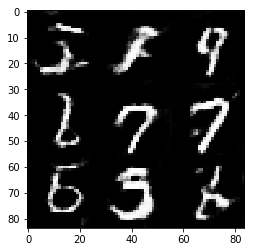

Epoch 1/2... Discriminator Loss: 0.8985... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.0980
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 1.0558... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 0.7602... Generator Loss: 1.8372
Epoch 1/2... Discriminator Loss: 0.6888... Generator Loss: 1.6481
Epoch 1/2... Discriminator Loss: 0.7443... Generator Loss: 1.8628
Epoch 1/2... Discriminator Loss: 0.9568... Generator Loss: 1.0679
Epoch 1/2... Discriminator Loss: 0.6375... Generator Loss: 2.0059
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 0.9203


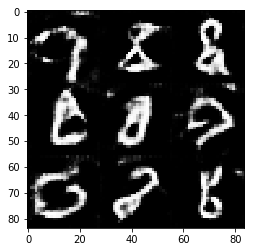

Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 0.7984
Epoch 1/2... Discriminator Loss: 1.0005... Generator Loss: 0.9138
Epoch 1/2... Discriminator Loss: 1.1456... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 1.3261... Generator Loss: 0.6172
Epoch 1/2... Discriminator Loss: 0.8521... Generator Loss: 1.6850
Epoch 1/2... Discriminator Loss: 1.2265... Generator Loss: 2.5655
Epoch 1/2... Discriminator Loss: 0.9061... Generator Loss: 2.0948
Epoch 1/2... Discriminator Loss: 0.7505... Generator Loss: 1.3795
Epoch 1/2... Discriminator Loss: 0.9930... Generator Loss: 1.0589


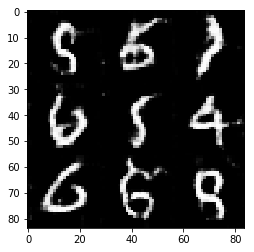

Epoch 1/2... Discriminator Loss: 0.6998... Generator Loss: 1.9302
Epoch 1/2... Discriminator Loss: 0.7468... Generator Loss: 2.1356
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 2.0341
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.1828
Epoch 2/2... Discriminator Loss: 1.0718... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.2688
Epoch 2/2... Discriminator Loss: 1.3229... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.8295
Epoch 2/2... Discriminator Loss: 0.8968... Generator Loss: 1.9672
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.1748


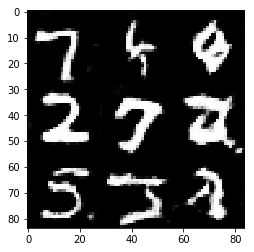

Epoch 2/2... Discriminator Loss: 0.7523... Generator Loss: 1.5980
Epoch 2/2... Discriminator Loss: 1.5009... Generator Loss: 0.5364
Epoch 2/2... Discriminator Loss: 1.0450... Generator Loss: 0.8880
Epoch 2/2... Discriminator Loss: 0.8806... Generator Loss: 1.1281
Epoch 2/2... Discriminator Loss: 2.1459... Generator Loss: 4.6181
Epoch 2/2... Discriminator Loss: 1.1963... Generator Loss: 0.7051
Epoch 2/2... Discriminator Loss: 0.9849... Generator Loss: 1.0501
Epoch 2/2... Discriminator Loss: 1.1018... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 0.8851... Generator Loss: 1.1797
Epoch 2/2... Discriminator Loss: 0.9207... Generator Loss: 1.0907


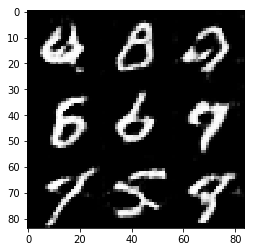

Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.1731
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.3165
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.7583
Epoch 2/2... Discriminator Loss: 2.2519... Generator Loss: 0.2645
Epoch 2/2... Discriminator Loss: 0.7163... Generator Loss: 2.2697
Epoch 2/2... Discriminator Loss: 0.7939... Generator Loss: 2.1327
Epoch 2/2... Discriminator Loss: 0.6257... Generator Loss: 1.8175
Epoch 2/2... Discriminator Loss: 0.9772... Generator Loss: 0.9985
Epoch 2/2... Discriminator Loss: 1.8021... Generator Loss: 0.4376
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.8246


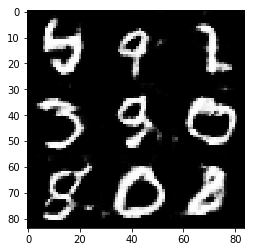

Epoch 2/2... Discriminator Loss: 2.0778... Generator Loss: 0.3042
Epoch 2/2... Discriminator Loss: 1.0439... Generator Loss: 2.8678
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 1.6864
Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.2751
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 1.2896
Epoch 2/2... Discriminator Loss: 1.2616... Generator Loss: 0.6543
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.4764
Epoch 2/2... Discriminator Loss: 0.6747... Generator Loss: 1.6628
Epoch 2/2... Discriminator Loss: 0.9454... Generator Loss: 1.0964
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.7106


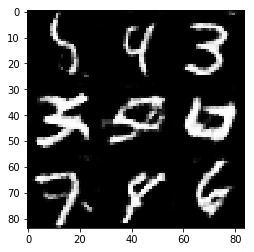

Epoch 2/2... Discriminator Loss: 1.3480... Generator Loss: 0.6767
Epoch 2/2... Discriminator Loss: 1.5818... Generator Loss: 0.7428
Epoch 2/2... Discriminator Loss: 0.6411... Generator Loss: 1.8649
Epoch 2/2... Discriminator Loss: 0.7167... Generator Loss: 1.6863
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.5168
Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 0.8529
Epoch 2/2... Discriminator Loss: 1.2253... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.5318
Epoch 2/2... Discriminator Loss: 0.9950... Generator Loss: 0.9061
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 2.8142


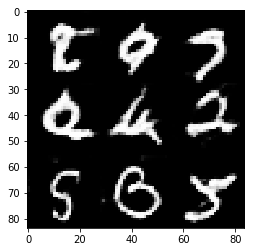

Epoch 2/2... Discriminator Loss: 1.5572... Generator Loss: 0.5058
Epoch 2/2... Discriminator Loss: 1.1898... Generator Loss: 0.8264
Epoch 2/2... Discriminator Loss: 0.9707... Generator Loss: 1.0741
Epoch 2/2... Discriminator Loss: 1.2856... Generator Loss: 0.7025
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.9526
Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 0.8875
Epoch 2/2... Discriminator Loss: 0.6391... Generator Loss: 1.6381
Epoch 2/2... Discriminator Loss: 0.7810... Generator Loss: 1.3888
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 0.7449


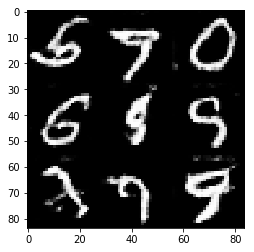

Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 2.2619
Epoch 2/2... Discriminator Loss: 1.8378... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 0.9684... Generator Loss: 0.9496
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.2143
Epoch 2/2... Discriminator Loss: 0.8614... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.6668
Epoch 2/2... Discriminator Loss: 0.8223... Generator Loss: 1.2106
Epoch 2/2... Discriminator Loss: 0.9282... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 1.1345... Generator Loss: 3.2210
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.6957


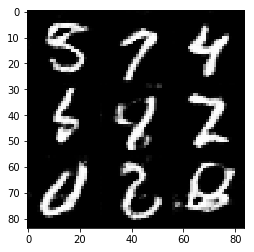

Epoch 2/2... Discriminator Loss: 1.0255... Generator Loss: 0.9970
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 2.4513
Epoch 2/2... Discriminator Loss: 0.8145... Generator Loss: 1.2245
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.9236
Epoch 2/2... Discriminator Loss: 1.5989... Generator Loss: 0.6059
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 3.4975
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.8504
Epoch 2/2... Discriminator Loss: 1.8618... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 2.3189
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.6102


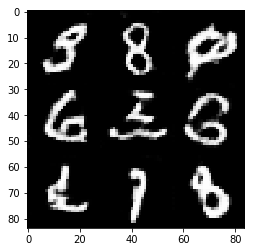

Epoch 2/2... Discriminator Loss: 0.8778... Generator Loss: 1.1144
Epoch 2/2... Discriminator Loss: 0.8458... Generator Loss: 1.2954
Epoch 2/2... Discriminator Loss: 1.8264... Generator Loss: 0.3615
Epoch 2/2... Discriminator Loss: 0.7030... Generator Loss: 1.7876
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 2.1824
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.8321
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 2.1093
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.8663
Epoch 2/2... Discriminator Loss: 1.0133... Generator Loss: 0.8786
Epoch 2/2... Discriminator Loss: 0.7554... Generator Loss: 3.1374


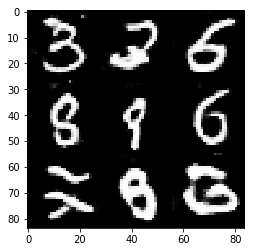

Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.7619
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 2.2415
Epoch 2/2... Discriminator Loss: 0.6699... Generator Loss: 1.6000
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 2.4684
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 0.6449
Epoch 2/2... Discriminator Loss: 0.9988... Generator Loss: 0.9073
Epoch 2/2... Discriminator Loss: 1.2409... Generator Loss: 0.8154


In [39]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

initial output:


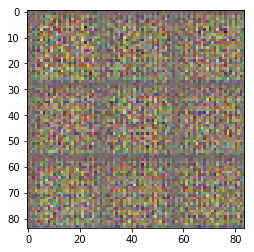

10-Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.2504
20-Epoch 1/1... Discriminator Loss: 3.3784... Generator Loss: 14.8023
30-Epoch 1/1... Discriminator Loss: 0.5416... Generator Loss: 2.9723
40-Epoch 1/1... Discriminator Loss: 0.4108... Generator Loss: 4.4052
50-Epoch 1/1... Discriminator Loss: 0.3764... Generator Loss: 4.4193
60-Epoch 1/1... Discriminator Loss: 0.3588... Generator Loss: 5.0251
70-Epoch 1/1... Discriminator Loss: 0.3782... Generator Loss: 7.1155
80-Epoch 1/1... Discriminator Loss: 0.3501... Generator Loss: 4.8161
90-Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 5.7505
100-Epoch 1/1... Discriminator Loss: 0.3437... Generator Loss: 6.9263


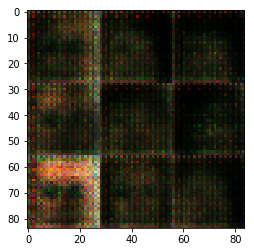

110-Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 7.0220
120-Epoch 1/1... Discriminator Loss: 0.3360... Generator Loss: 7.3247
130-Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 7.4680
140-Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 5.3269
150-Epoch 1/1... Discriminator Loss: 0.3749... Generator Loss: 8.1179
160-Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 7.4792
170-Epoch 1/1... Discriminator Loss: 0.3294... Generator Loss: 6.6616
180-Epoch 1/1... Discriminator Loss: 0.3301... Generator Loss: 6.6940
190-Epoch 1/1... Discriminator Loss: 0.3304... Generator Loss: 6.5569
200-Epoch 1/1... Discriminator Loss: 0.3341... Generator Loss: 6.2126


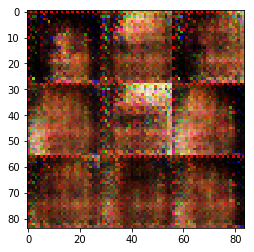

210-Epoch 1/1... Discriminator Loss: 0.3283... Generator Loss: 6.8507
220-Epoch 1/1... Discriminator Loss: 0.3291... Generator Loss: 6.4574
230-Epoch 1/1... Discriminator Loss: 0.3288... Generator Loss: 6.6738
240-Epoch 1/1... Discriminator Loss: 4.7479... Generator Loss: 0.2873
250-Epoch 1/1... Discriminator Loss: 0.4709... Generator Loss: 2.5675
260-Epoch 1/1... Discriminator Loss: 0.7049... Generator Loss: 4.3673
270-Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 1.7393
280-Epoch 1/1... Discriminator Loss: 1.9449... Generator Loss: 0.4038
290-Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 2.1716
300-Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 3.9827


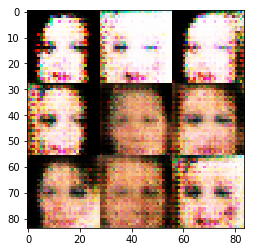

310-Epoch 1/1... Discriminator Loss: 0.9468... Generator Loss: 1.4208
320-Epoch 1/1... Discriminator Loss: 0.7885... Generator Loss: 1.7708
330-Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9289
340-Epoch 1/1... Discriminator Loss: 2.2590... Generator Loss: 3.0654
350-Epoch 1/1... Discriminator Loss: 0.8622... Generator Loss: 1.5996
360-Epoch 1/1... Discriminator Loss: 0.7846... Generator Loss: 1.3533
370-Epoch 1/1... Discriminator Loss: 0.7564... Generator Loss: 2.2111
380-Epoch 1/1... Discriminator Loss: 0.5964... Generator Loss: 1.8066
390-Epoch 1/1... Discriminator Loss: 0.5183... Generator Loss: 2.1411
400-Epoch 1/1... Discriminator Loss: 1.1226... Generator Loss: 2.9632


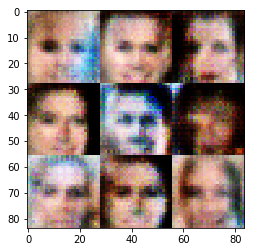

410-Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.7625
420-Epoch 1/1... Discriminator Loss: 0.8892... Generator Loss: 1.1147
430-Epoch 1/1... Discriminator Loss: 1.1573... Generator Loss: 0.6951
440-Epoch 1/1... Discriminator Loss: 0.9035... Generator Loss: 1.0702
450-Epoch 1/1... Discriminator Loss: 0.5811... Generator Loss: 2.0873
460-Epoch 1/1... Discriminator Loss: 0.8724... Generator Loss: 1.7349
470-Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.5563
480-Epoch 1/1... Discriminator Loss: 0.4352... Generator Loss: 3.9689
490-Epoch 1/1... Discriminator Loss: 0.6452... Generator Loss: 1.4686
500-Epoch 1/1... Discriminator Loss: 0.7134... Generator Loss: 1.5828


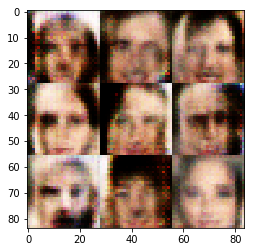

510-Epoch 1/1... Discriminator Loss: 0.7242... Generator Loss: 3.4365
520-Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 3.2963
530-Epoch 1/1... Discriminator Loss: 0.7819... Generator Loss: 1.2759
540-Epoch 1/1... Discriminator Loss: 0.9298... Generator Loss: 1.1505
550-Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.7425
560-Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 2.0002
570-Epoch 1/1... Discriminator Loss: 0.5141... Generator Loss: 2.3149
580-Epoch 1/1... Discriminator Loss: 0.7372... Generator Loss: 1.3411
590-Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.5902
600-Epoch 1/1... Discriminator Loss: 0.7900... Generator Loss: 1.7797


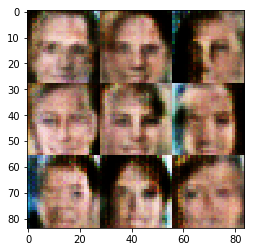

610-Epoch 1/1... Discriminator Loss: 1.3455... Generator Loss: 0.5594
620-Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.3154
630-Epoch 1/1... Discriminator Loss: 0.8692... Generator Loss: 1.3262
640-Epoch 1/1... Discriminator Loss: 0.8918... Generator Loss: 1.5167
650-Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 2.0963
660-Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.0119
670-Epoch 1/1... Discriminator Loss: 0.8503... Generator Loss: 1.0607
680-Epoch 1/1... Discriminator Loss: 1.1479... Generator Loss: 0.6714
690-Epoch 1/1... Discriminator Loss: 0.9378... Generator Loss: 2.9719
700-Epoch 1/1... Discriminator Loss: 0.9754... Generator Loss: 0.9705


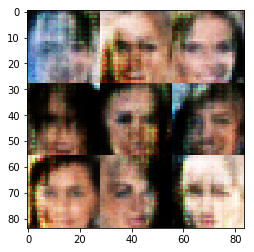

710-Epoch 1/1... Discriminator Loss: 0.6658... Generator Loss: 2.8955
720-Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.9799
730-Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 2.2609
740-Epoch 1/1... Discriminator Loss: 1.0069... Generator Loss: 1.8638
750-Epoch 1/1... Discriminator Loss: 1.0086... Generator Loss: 0.8831
760-Epoch 1/1... Discriminator Loss: 0.9539... Generator Loss: 1.0763
770-Epoch 1/1... Discriminator Loss: 1.1834... Generator Loss: 1.4654
780-Epoch 1/1... Discriminator Loss: 0.9090... Generator Loss: 1.1836
790-Epoch 1/1... Discriminator Loss: 0.8302... Generator Loss: 1.1505
800-Epoch 1/1... Discriminator Loss: 1.4680... Generator Loss: 2.6140


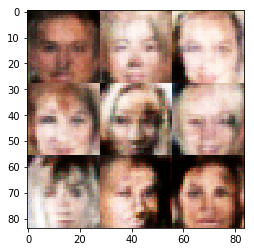

810-Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 1.0226
820-Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 3.3811
830-Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 1.5662
840-Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 1.4160
850-Epoch 1/1... Discriminator Loss: 0.8450... Generator Loss: 1.6623
860-Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6094
870-Epoch 1/1... Discriminator Loss: 0.4750... Generator Loss: 2.9142
880-Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 0.8108
890-Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 1.0712
900-Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6375


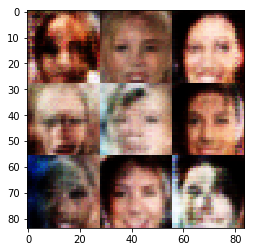

910-Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 1.5149
920-Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 0.8197
930-Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.3580
940-Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.7647
950-Epoch 1/1... Discriminator Loss: 0.8826... Generator Loss: 1.2525
960-Epoch 1/1... Discriminator Loss: 0.9590... Generator Loss: 1.4966
970-Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.9989
980-Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.0342
990-Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8249
1000-Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.5382


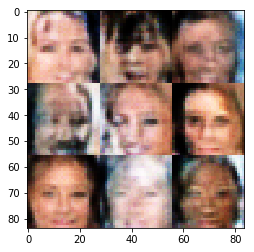

1010-Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 1.4237
1020-Epoch 1/1... Discriminator Loss: 1.6951... Generator Loss: 3.9819
1030-Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.8910
1040-Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.0802
1050-Epoch 1/1... Discriminator Loss: 0.8367... Generator Loss: 1.4360
1060-Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 1.6019
1070-Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.4495
1080-Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 1.2560
1090-Epoch 1/1... Discriminator Loss: 0.9270... Generator Loss: 1.6366
1100-Epoch 1/1... Discriminator Loss: 1.0222... Generator Loss: 0.9203


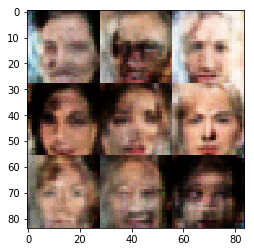

1110-Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.7654
1120-Epoch 1/1... Discriminator Loss: 0.7285... Generator Loss: 1.7680
1130-Epoch 1/1... Discriminator Loss: 0.9067... Generator Loss: 1.5850
1140-Epoch 1/1... Discriminator Loss: 1.0503... Generator Loss: 1.1225
1150-Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 3.2264
1160-Epoch 1/1... Discriminator Loss: 0.7044... Generator Loss: 2.4389
1170-Epoch 1/1... Discriminator Loss: 2.3027... Generator Loss: 0.2122
1180-Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.8102
1190-Epoch 1/1... Discriminator Loss: 1.2743... Generator Loss: 1.8526
1200-Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 0.9752


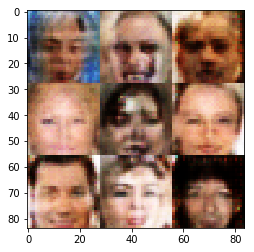

1210-Epoch 1/1... Discriminator Loss: 0.9783... Generator Loss: 1.0257
1220-Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5406
1230-Epoch 1/1... Discriminator Loss: 0.9761... Generator Loss: 0.8716
1240-Epoch 1/1... Discriminator Loss: 0.9145... Generator Loss: 1.8793
1250-Epoch 1/1... Discriminator Loss: 0.7661... Generator Loss: 1.7548
1260-Epoch 1/1... Discriminator Loss: 1.7456... Generator Loss: 1.0223
1270-Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.1833
1280-Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7896
1290-Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.9759
1300-Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 1.1460


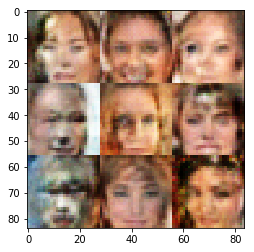

1310-Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.2428
1320-Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.9451
1330-Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 1.6173
1340-Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.6545
1350-Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.0887
1360-Epoch 1/1... Discriminator Loss: 1.0654... Generator Loss: 0.8565
1370-Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0906
1380-Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.8858
1390-Epoch 1/1... Discriminator Loss: 1.0630... Generator Loss: 1.6597
1400-Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 0.9442


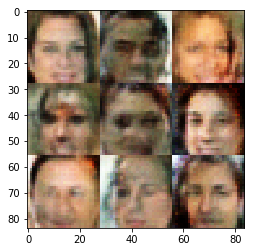

1410-Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 1.7710
1420-Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 1.1521
1430-Epoch 1/1... Discriminator Loss: 1.1657... Generator Loss: 1.8121
1440-Epoch 1/1... Discriminator Loss: 0.8875... Generator Loss: 1.1604
1450-Epoch 1/1... Discriminator Loss: 0.9309... Generator Loss: 1.0522
1460-Epoch 1/1... Discriminator Loss: 2.3879... Generator Loss: 0.2521
1470-Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 1.7688
1480-Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 0.7096
1490-Epoch 1/1... Discriminator Loss: 0.9117... Generator Loss: 1.6827
1500-Epoch 1/1... Discriminator Loss: 1.1191... Generator Loss: 1.0121


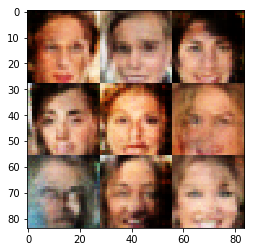

1510-Epoch 1/1... Discriminator Loss: 0.9130... Generator Loss: 1.8200
1520-Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.7531
1530-Epoch 1/1... Discriminator Loss: 0.8045... Generator Loss: 2.1139
1540-Epoch 1/1... Discriminator Loss: 1.9059... Generator Loss: 2.5247
1550-Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.9415
1560-Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.4054
1570-Epoch 1/1... Discriminator Loss: 1.1357... Generator Loss: 2.3805
1580-Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.9254


In [44]:
batch_size = 128
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.